# Introdução

**Nesse primeiro notebook, nosso propósito é fazer uma análise inicial dos dados do dataset de bicicletas compartilhadas de nova iorque e entender suas peculiaridades nos dados.**

# Importações

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import pyarrow.parquet as pq
from haversine import haversine
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go
from prettytable import PrettyTable
from sklearn import metrics
import math

plt.style.use('fivethirtyeight')
warnings.simplefilter("ignore")

In [2]:
px.set_mapbox_access_token("pk.eyJ1Ijoicm1jbnJpYmVpcm8iLCJhIjoiY2s4MHh5b3ZiMGtsbTNkcGFuazR1dWc4diJ9._aDTNPlmw3Nt6QSMm3YgmQ")

**Importante**: Devido a restrição de espaço no Github, baixe os dados do Drive e coloque localmente na pasta 'Dados'.
https://drive.google.com/drive/folders/144_0BrEXS3Z1VslYxr1rP2Wr6bSm4tDf?usp=sharing

In [3]:
url='https://drive.google.com/file/d/1x74szuO_xoNyQqeBrn6df6HmzCMv-QQ5/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_trips_filtrado = pd.read_parquet(url)

In [4]:
df_trips_filtrado

Trip Duration              Start Time               Stop Time  \
0                 882 2018-11-25 18:21:38.774 2018-11-25 18:36:21.472   
1                 669 2018-08-13 18:25:50.544 2018-08-13 18:36:59.968   
2                 521 2018-12-18 20:12:15.062 2018-12-18 20:20:57.017   
3                 270 2018-05-18 14:23:52.105 2018-05-18 14:28:22.491   
4                 441 2018-08-14 19:00:15.867 2018-08-14 19:07:37.052   
...               ...                     ...                     ...   
999995           1658 2019-06-12 22:09:26.375 2019-06-12 22:37:05.244   
999996            294 2019-10-04 15:13:45.883 2019-10-04 15:18:40.101   
999997           1386 2019-06-09 13:46:00.828 2019-06-09 14:09:07.822   
999998           1648 2019-09-26 17:48:29.830 2019-09-26 18:15:57.963   
999999            506 2019-05-29 16:56:05.696 2019-05-29 17:04:32.584   

        Start Station ID          Start Station Name  Start Station Latitude  \
0                    423             W 54 St & 9 Ave               40.765849   
1                   3467  W Broadway & Spring Street               40.724947   
2                    411           E 6 St & Avenue D               40.722281   
3                    437     Macon St & Nostrand Ave               40.680983   
4                    519       Pershing Square North               40.751873   
...                  ...                         ...                     ...   
999995              3310               14 St & 7 Ave               40.663779   
999996              3062      Myrtle Ave & Marcy Ave               40.695398   
999997               311      Norfolk St & Broome St               40.717227   
999998               266           Avenue D & E 8 St               40.723684   
999999              3345       Madison Ave & E 99 St               40.789485   

        Start Station Longitude  End Station ID              End Station Name  \
0                    -73.986905             476               E 31 St & 3 Ave   
1                    -74.001659             327      Vesey Pl & River Terrace   
2                    -73.976687             504               1 Ave & E 16 St   
3                    -73.950048            3047      Halsey St & Tompkins Ave   
4                    -73.977706             498            Broadway & W 32 St   
...                         ...             ...                           ...   
999995               -73.983968             414       Pearl St & Anchorage Pl   
999996               -73.949549             373  Willoughby Ave & Walworth St   
999997               -73.988021             143     Clinton St & Joralemon St   
999998               -73.975748            3680               E 43 St & 5 Ave   
999999               -73.952429            3507           Park Ave & E 124 St   

        End Station Latitude  ...  Start Month  Start Hours Start Weekday  \
0                  40.743943  ...     November           18             6   
1                  40.715338  ...       August           18             0   
2                  40.732219  ...     December           20             1   
3                  40.682369  ...          May           14             4   
4                  40.748549  ...       August           19             1   
...                      ...  ...          ...          ...           ...   
999995             40.702819  ...         June           22             2   
999996             40.693317  ...      October           15             4   
999997             40.692395  ...         June           13             6   
999998             40.754121  ...    September           17             3   
999999             40.804555  ...          May           16             2   

        Start Weekday Name  Trip Duration Minutes Age  Age Group  isweekend  \
0                   Sunday                     15  50      40-49       True   
1                   Monday                     11  32      30-39      False   
2                  Tuesday         

# Análise de Sazonalidade

## Construção da Série Temporal

In [5]:
df_time_series = df_trips_filtrado.copy()

In [6]:
df = df_time_series.copy()
df["Date-Hour"] = df["Start Time"].dt.floor("H").copy()
usage_series = df.groupby("Date-Hour").size().asfreq("h")

In [7]:
usage_series.head()

Date-Hour
2018-01-01 00:00:00    4.0
2018-01-01 01:00:00    5.0
2018-01-01 02:00:00    4.0
2018-01-01 03:00:00    1.0
2018-01-01 04:00:00    NaN
Freq: H, dtype: float64

In [8]:
# Precisamos que o dataframe tenha a propriedade de frequência por hora
usage_series = usage_series.asfreq('h')

In [9]:
# Precisamos preencher os buracos vazios com uma interpolação
usage_series = usage_series.interpolate()

<AxesSubplot:xlabel='Date-Hour'>

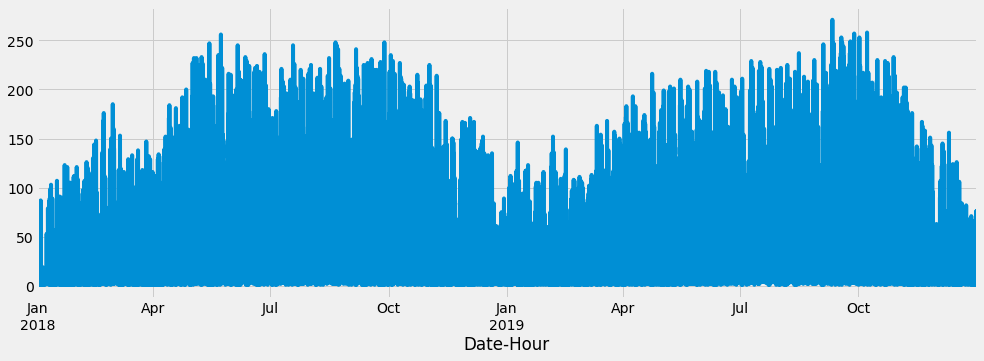

In [10]:
usage_series.plot(figsize=(15,5))

## Análise da Decomposição de Sazonalidade

No estudo de séries temporais a sazonalidade é uma questão importante pois define o padrão de comportamento da série. Uma técnica de estudo de sazonalidade é a partir da decomposição em três partes:

* **Tendência:** Define a análise macro do comportamento da curva, que é a tendência geral para cada ponto da série.
* **Sazonalidade:** Define os padrões mais localizados/micros da curva.
* **Resíduo:** Todo o restante que não pode ser predito. Essa é uma medida importante porque em teoria deve ser aleatória, não demonstrando padrões nos resíduos. Se houverem razões podemos concluir que nosso modelo de decomposição não entende completamente os dados e está perdendo padrões.

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

https://otexts.com/fpp3/

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
result = seasonal_decompose(usage_series, model='additive')

<AxesSubplot:xlabel='Date-Hour'>

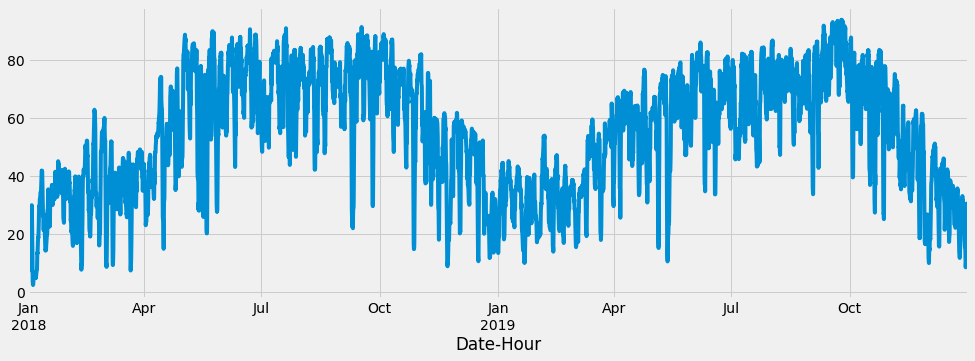

In [13]:
result.trend.plot(figsize=(15,5))

Podemos ver que a tendência capturou uma alta de acordo com os meses mais centrais do ano. Além disso, podemos ver que ela capturou curvas semanais, indicando o comportamento de sazonalidades semanais.

**Importante**: A tendência deve ser uma curva muito linear, pois não deve levar em consideração as volatilidades micro. O significado dessa sazonalidade embutida na tendência é que nossa componente de sazonalidade não deu conta de descobrir todos os padrões. Isso porque podemos encontrar três sazonalidades nos nossos dados: horária, diária e semanal. Podemos até encontrar uma anual se quisermos.

<AxesSubplot:xlabel='Date-Hour'>

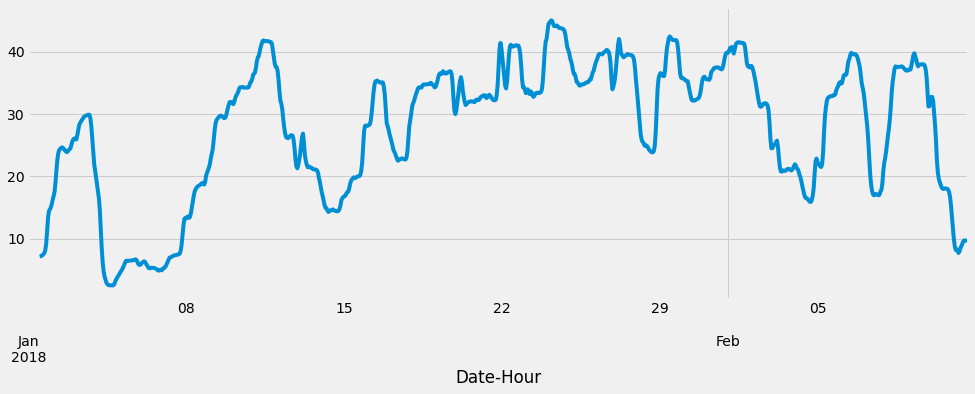

In [14]:
result.trend[:1000].plot(figsize=(15,5))

Na análise da sazonalidade podemos ver que capturou a sazonalidade diária. Em uma análise mais profunda podemos ainda ver que essa é a sazonalidade dos dias de semana, visto que o comportamento dos fins de semana é diferente. Isso mostra como as múltiplas sazonalidades não foram captadas.

<AxesSubplot:xlabel='Date-Hour'>

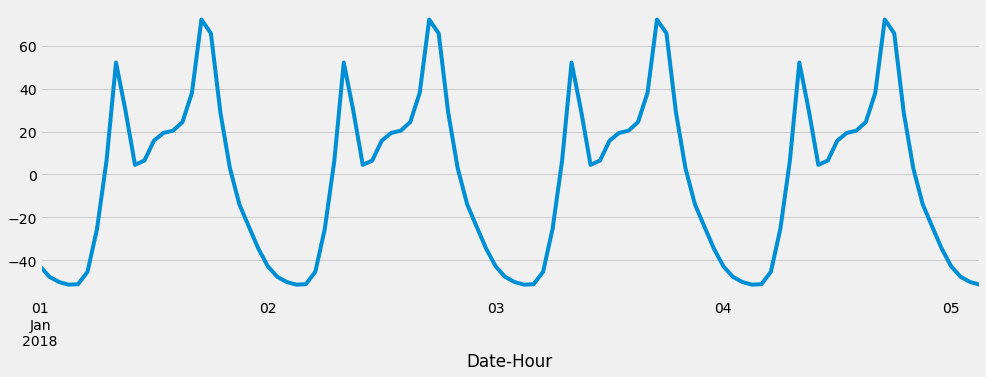

In [15]:
result.seasonal[:100].plot(figsize=(15,5))

Com os resíduos também podemos ver as sazonalidades que escaparam do modelo.

<AxesSubplot:xlabel='Date-Hour'>

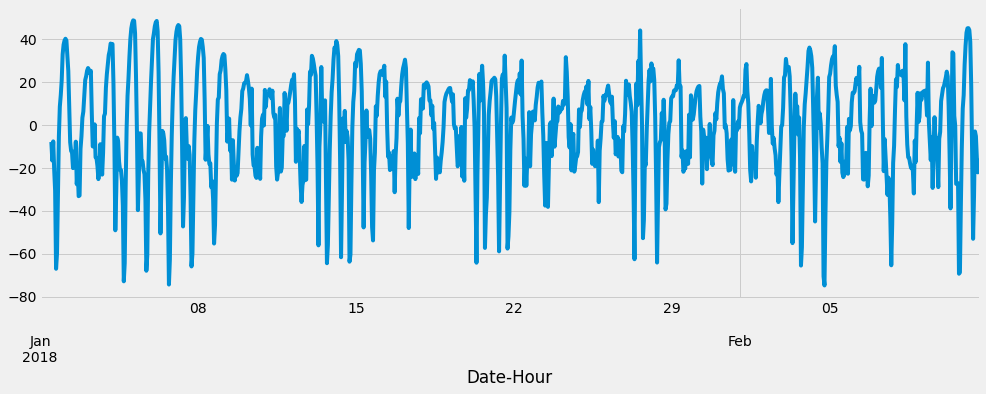

In [16]:
result.resid[:1000].plot(figsize=(15,5))

<AxesSubplot:xlabel='Date-Hour'>

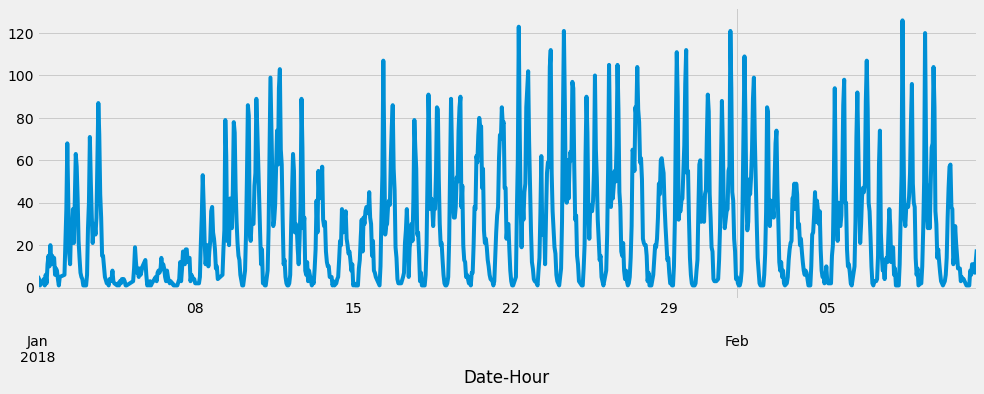

In [17]:
result.observed[:1000].plot(figsize=(15,5))

# Predição de Série Temporal

In [18]:
split_index = int(len(usage_series) * 0.5)

train_series = usage_series.iloc[:split_index]
test_series = usage_series.iloc[split_index:]
train_series = train_series.to_frame(name='count').to_period("H")
test_series = test_series.to_frame(name='count').to_period("H")

In [19]:
# Preparando tabela de metricas
table = PrettyTable()
table.field_names = ['Modelo', 'RMSR', 'MAPE', 'MAE', 'MSE']

In [20]:
def get_matrics(algorithm, y_actual, y_pred):
    mae_m = metrics.mean_absolute_error(y_actual, y_pred)
    mse_m = metrics.mean_squared_error(y_actual, y_pred)
    rmse_m = math.sqrt(mse_m)
    mape_m = metrics.mean_absolute_percentage_error(y_actual, y_pred)
    print(f"RMSR: {rmse_m}")
    print(f"MAPE: {mape_m}")
    print(f"MAE: {mae_m}")
    print(f"MSE: {mse_m}")
    return algorithm, rmse_m, mape_m, mae_m, mse_m

## FourierCalendar + Regressão Linear | Árvore de Regressão | XGBoost

https://www.kaggle.com/code/ryanholbrook/seasonality

<AxesSubplot:xlabel='Date-Hour'>

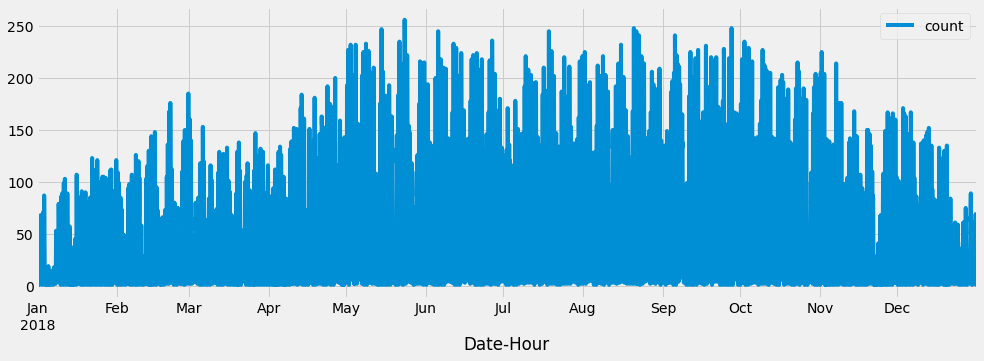

In [21]:
train_series.plot(figsize=(15,5))

In [22]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=365)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=train_series.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_train = dp.in_sample()  # create features for dates in tunnel.index
y_train = train_series['count']

In [23]:
superior = train_series.quantile(0.95)[0]
inferior = train_series.quantile(0.05)[0]

In [24]:
X_train["isweekend"] = ((X_train.index.dayofweek == 5) | (X_train.index.dayofweek == 6)).astype(int)
X_train["outlier"] = np.where(train_series['count'] > superior, 1 ,np.where(train_series['count'] < inferior,-1,0))

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
import xgboost as xgb

In [26]:
# Modelos de regressão
modelo = xgb.XGBRegressor(n_estimators=10).fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)
# modelo = LinearRegression(fit_intercept=False).fit(X_train, y_train)
# modelo = RandomForestRegressor(n_estimators=10, random_state=1).fit(X_train, y_train)
# modelo = DecisionTreeRegressor(random_state = 0).fit(X_train, y_train)

# Amostra de saida do Fourier
X_test = dp.out_of_sample(len(test_series))
X_test["isweekend"] = ((X_test.index.dayofweek == 5) | (X_test.index.dayofweek == 6)).astype(int)
X_test["outlier"] = np.where(test_series['count'] > superior, 1 ,np.where(test_series['count'] < inferior,-1,0))

In [27]:
# Predição
y_pred = pd.Series(modelo.predict(X_test), index=X_test.index)

In [28]:
# Metrica
modelo, rmsr, mape, mae, mse = get_matrics('Calendar Fourier', test_series, y_pred)
table.add_row([modelo, round(rmsr,5), round(mape,5), round(mae,5), round(mse,5)])

RMSR: 25.031134124760648
MAPE: 0.6104902770819409
MAE: 16.832841417203394
MSE: 626.5576755717569


In [29]:
comparison = pd.DataFrame({
    "Original": test_series['count'],
    "Predição": y_pred
})
comparison.index.name = 'Dias'
px.line(comparison.to_timestamp())

## Random Forest Regressor

Random Forest é uma técnica capaz de realizar tanto tarefas de regressão quanto de classificação com o uso de múltiplas árvores de decisão e técnicas chamadas Bootstrap e Aggregation.

In [30]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

In [31]:
data = pd.DataFrame()
data['Start Time'] = df_trips_filtrado['Start Time'].dt.round('h').copy()
data = data.groupby(['Start Time']).size().reset_index(name='Count Trip')

Com uma análise visual, é possível identificar uma média constante ao longo do tempo e depois uma pequena queda por conta do inverno, e temos alguns outliers (positivos e negativos) recorrentes. Vamos usar a análise de quantiles para lider com os outliers, criando uma variável que admite valores `-1` (outlier negativo), `0` (sem outlier) e `1` (outlier positivo) quando o dado está acima de 95% ou abaixo de 5% na distribuição.

In [32]:
# Realizando os limitadores de marcação de outlier
superior = data.set_index("Start Time").quantile(0.95)[0]
inferior = data.set_index("Start Time").quantile(0.05)[0]
data["Outlier"] = np.where(data['Count Trip'] > superior, 1 ,np.where(data['Count Trip'] < inferior,-1,0))

In [33]:
# Adicionando novas colunas para melhor avaliação
data['Hour'] = data['Start Time'].dt.hour
data['Day Week'] = data['Start Time'].dt.weekday
data['Weekend'] = data['Start Time'].apply(applyer)
data.set_index('Start Time', inplace=True)

In [34]:
treino = data.iloc[:split_index]
teste = data.iloc[split_index:]

X_treino = treino.drop('Count Trip', axis=1)
y_treino = treino['Count Trip']

X_teste = teste.drop('Count Trip', axis=1)
y_teste = teste['Count Trip']

In [35]:
# Treinando
rfr = RandomForestRegressor(n_estimators=500, random_state=1)
rfr.fit(X_treino, y_treino)
 
# Previsao
y_pred = rfr.predict(X_teste)

# Métrica
modelo, rmsr, mape, mae, mse = get_matrics('Randon Forest Regressor', y_teste, y_pred)
table.add_row([modelo, round(rmsr,5), round(mape,5), round(mae,5), round(mse,5)])

RMSR: 24.417526074814788
MAPE: 0.5724044565824473
MAE: 17.53344599504778
MSE: 596.21557961426


In [36]:
comparison = pd.DataFrame({
    "Original": y_teste,
    "Predição": y_pred
})
comparison.index.name = 'Dias'
px.line(comparison)

## XGBoost

In [37]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_treino, y_treino,
        eval_set=[(X_treino, y_treino), (X_teste, y_teste)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Podemos ver a importancia dos recusos. Está é uma metrica que simplismente resume quantas vezes cada rescurso é dividido.

E podemos notar que as horas é os dividido na árvore.

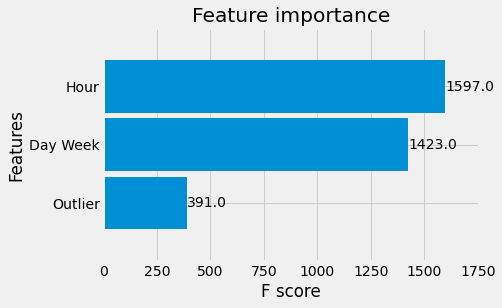

In [38]:
xgb.plot_importance(reg, height=0.9)
plt.show()

In [39]:
# Previsão
y_pred = reg.predict(X_teste)

# Métrica
modelo, rmsr, mape, mae, mse = get_matrics('XGBoost', y_teste, y_pred)
table.add_row([modelo, round(rmsr,5), round(mape,5), round(mae,5), round(mse,5)])

RMSR: 24.399033520477985
MAPE: 0.5823151324962287
MAE: 17.53641660784888
MSE: 595.3128367334083


In [40]:
comparison = pd.DataFrame({
    "Original": y_teste,
    "Predição": y_pred
})
comparison.index.name = 'Dias'
px.line(comparison)

## ARIMA

In [41]:
y_treino.index = pd.DatetimeIndex(y_treino.index).to_period('H')

In [42]:
from statsmodels.tsa.arima.model import ARIMA

In [43]:
# treinamento
model_fit = ARIMA(y_treino, order=(2, 0, 1)).fit()

# Predição
y_pred = model_fit.predict(0, len(y_teste)-1, typ='levels')

# Métrica
modelo, rmsr, mape, mae, mse = get_matrics('Arima', y_teste, y_pred)
table.add_row([modelo, round(rmsr,5), round(mape,5), round(mae,5), round(mse,5)])

RMSR: 68.21773298411259
MAPE: 5.352943899485453
MAE: 53.17386453238744
MSE: 4653.659093491683


In [44]:
comparison = pd.DataFrame({
    "Original": y_teste,
    "Predição": y_pred.values
})
comparison.index.name = 'Dias'
px.line(comparison)

## SARIMAX

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
# Treinamento
result = SARIMAX(y_treino, order = (2, 0, 1), seasonal_order =(2, 1, 1, 12)).fit()

# Predição
predictions = result.predict(0, len(y_teste)-1, typ = 'levels').rename("Predictions")

# Métrica
modelo, rmsr, mape, mae, mse = get_matrics('Sarimax', y_teste, y_pred)
table.add_row([modelo, round(rmsr,5), round(mape,5), round(mae,5), round(mse,5)])

RMSR: 68.21773298411259
MAPE: 5.352943899485453
MAE: 53.17386453238744
MSE: 4653.659093491683


In [47]:
comparison = pd.DataFrame({
    "Original": y_teste,
    "Predição": y_pred.values
})
comparison.index.name = 'Dias'
px.line(comparison)

## Previsão com Facebook's Prophet

O Prophet é um procedimento para prever dados de séries temporais com base em um modelo aditivo em que as tendências não lineares são ajustadas à sazonalidade anual, semanal e diária, além dos efeitos de feriados. Funciona melhor com séries temporais com fortes efeitos sazonais e várias temporadas de dados históricos. Porém como ja falado o nosso periodo é de 1 ano.

In [48]:
from prophet import Prophet

In [49]:
# Preparação e agrupamento dos dados
df_prophet = pd.DataFrame()
df_prophet['Start Time'] = df_trips_filtrado['Start Time'].dt.round('h').copy()
df_prophet = df_prophet.groupby(['Start Time']).size().reset_index(name='Count Trip')

In [50]:
# Reciclando treinamento e teste ja usados
prophet_train = treino.copy()
prophet_test = teste.copy()

prophet_train.drop(['Hour', 'Day Week', 'Weekend'], axis=1, inplace= True)
prophet_test.drop(['Count Trip', 'Hour', 'Day Week', 'Weekend'], axis=1, inplace=True)

A entrada para Prophet é sempre um dataframe com duas colunas: ds e y. A coluna ds (datastamp) deve ter um formato esperado pelos Pandas, idealmente AAAA-MM-DD para uma data ou AAAA-MM-DD HH:MM:SS. A coluna y deve ser numérica e representa a medida que desejamos prever.

Vamos sempre renomear nossas colunas de dataframe antes de alimentá-las no modelo.

In [51]:
prophet_train.reset_index().rename(columns={'Start Time':'ds','Count Trip':'y'}).head()

ds  y  Outlier
0 2018-01-01 00:00:00  2        0
1 2018-01-01 01:00:00  4        0
2 2018-01-01 02:00:00  4        0
3 2018-01-01 03:00:00  4        0
4 2018-01-01 07:00:00  1       -1

In [52]:
# Treinamento
model = Prophet()
model.fit(prophet_train.reset_index().rename(columns={'Start Time':'ds', 'Count Trip':'y'}))

13:10:17 - cmdstanpy - INFO - Chain [1] start processing
13:10:19 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
# Predição
prophet_test_fcst = model.predict(df=prophet_test.reset_index().rename(columns={'Dias':'ds'}))

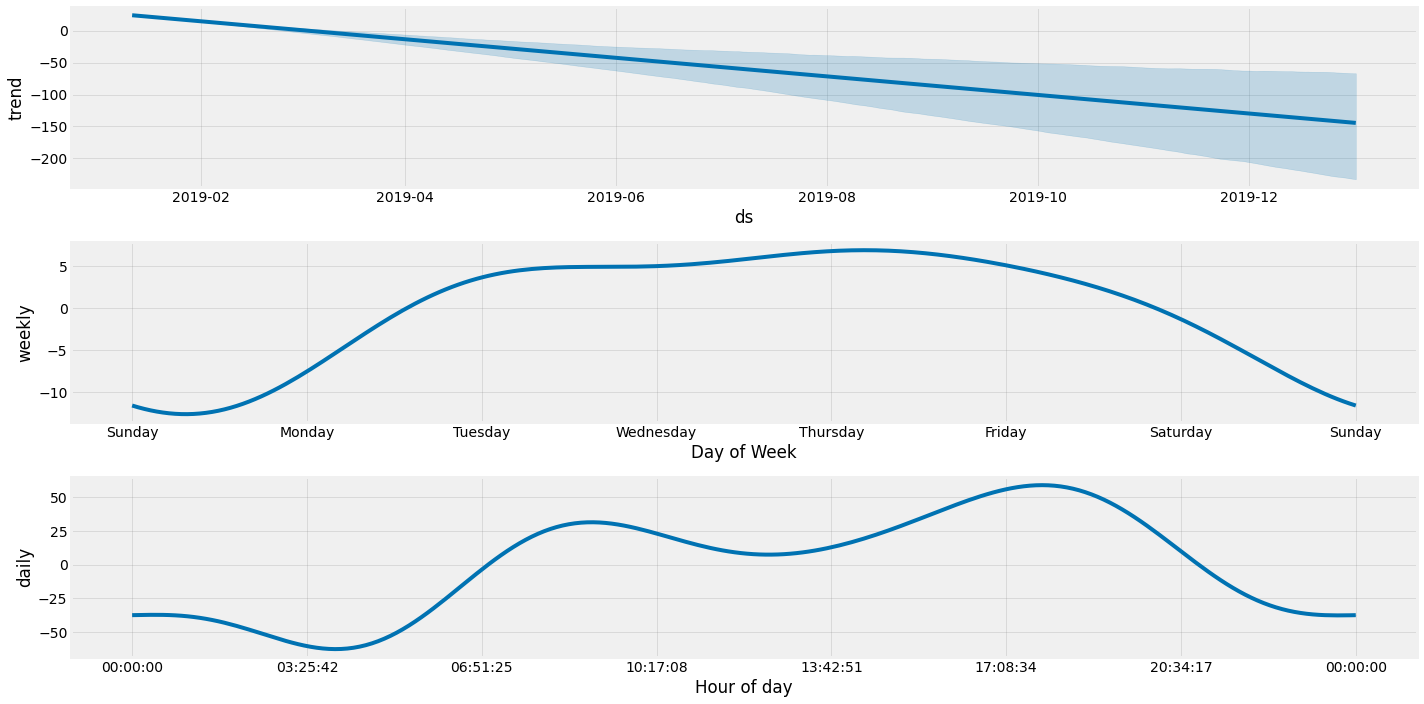

In [54]:
# Componentes previstos pelo prophet
fig = model.plot_components(prophet_test_fcst, figsize=(20,10))

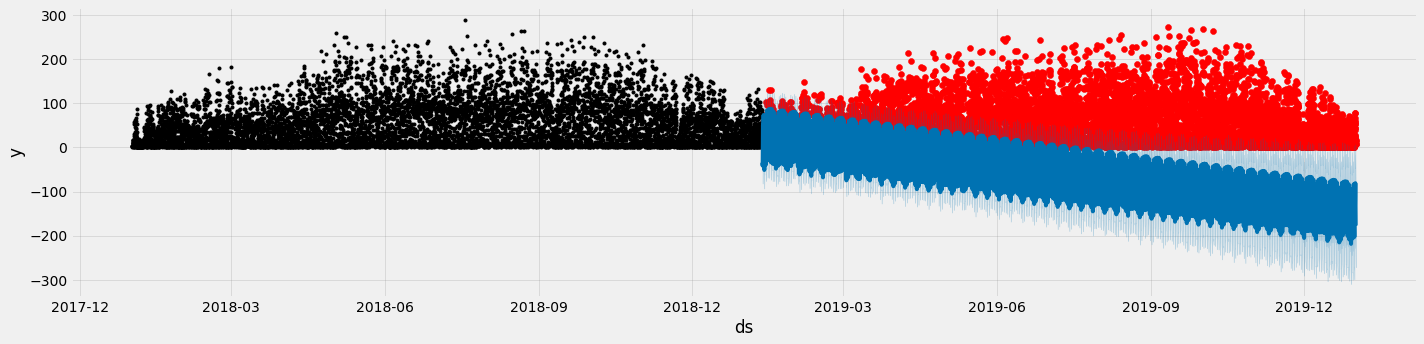

In [55]:
# Gráfico preditivo
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(teste.index, teste['Count Trip'], color='r')
fig = model.plot(prophet_test_fcst, ax=ax)

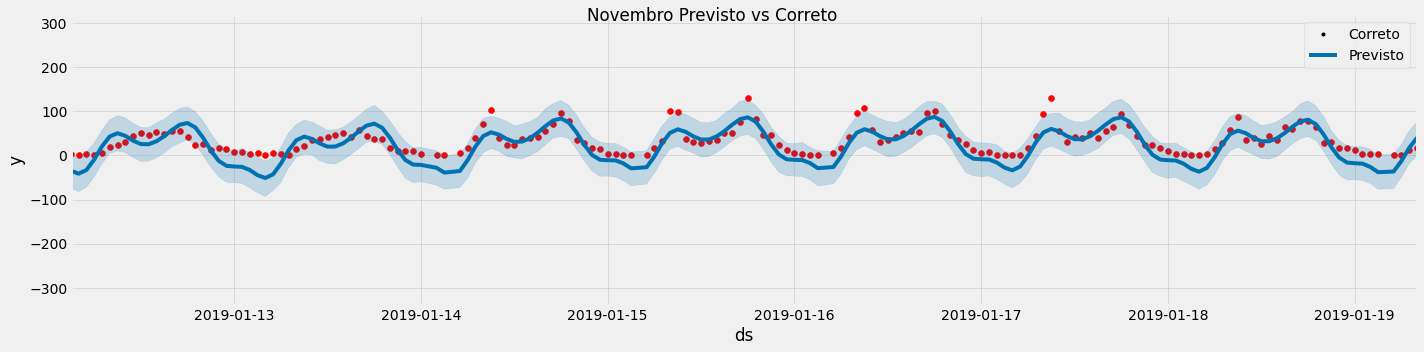

In [56]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(teste.index, teste['Count Trip'], color='r')
fig = model.plot(prophet_test_fcst, ax=ax)
ax.set_xbound(lower=teste.index[0],
              upper=teste.index[24*7])
plt.legend(['Correto', 'Previsto'])
plot = plt.suptitle('Novembro Previsto vs Correto')

In [57]:
# Métrica
modelo, rmsr, mape, mae, mse = get_matrics('Prophet', y_teste, prophet_test_fcst['yhat'])
table.add_row([modelo, round(rmsr,5), round(mape,5), round(mae,5), round(mse,5)])

RMSR: 131.35699405616012
MAPE: 10.183808708295123
MAE: 116.57488549119681
MSE: 17254.659887470083


## Resultado das Métricas

In [58]:
table

+-------------------------+-----------+----------+-----------+-------------+
|          Modelo         |    RMSR   |   MAPE   |    MAE    |     MSE     |
+-------------------------+-----------+----------+-----------+-------------+
|     Calendar Fourier    |  25.03113 | 0.61049  |  16.83284 |  626.55768  |
| Randon Forest Regressor |  24.41753 |  0.5724  |  17.53345 |  596.21558  |
|         XGBoost         |  24.39903 | 0.58232  |  17.53642 |  595.31284  |
|          Arima          |  68.21773 | 5.35294  |  53.17386 |  4653.65909 |
|         Sarimax         |  68.21773 | 5.35294  |  53.17386 |  4653.65909 |
|         Prophet         | 131.35699 | 10.18381 | 116.57489 | 17254.65989 |
+-------------------------+-----------+----------+-----------+-------------+